In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import requests
import networkx

from io import StringIO

%matplotlib inline

In [2]:
url = "https://docs.google.com/spreadsheet/ccc?key=1R7DCtKMu_3jnNx1RpcK79pIC317g3bk1p-wfcApX8PA&output=csv"

In [4]:
response = requests.get(url)
df = pd.read_csv(StringIO(response.content.decode("utf-8"))).set_index("Title").iloc[:8, 2:].astype(np.int)

In [5]:
df

,Matthias,Aljoscha,Lukas,Ines,Ronny,Georg,Jesus,Etienne,Amalia,Maria,Christian,Anna,Diesel,Abhishek,Florian,Nadya,Michi,Tabea,Jonatan,Sandra
Title,,,,,,,,,,,,,,,,,,,,
Ancient Times,3,2,2,1,1,1,4,3,4,1,2,2,6,3,3,3,1,2,1,2
Asterix and Obelix,6,5,4,3,8,2,8,1,3,6,1,8,2,7,2,8,4,4,2,6
Fairy Tales,8,7,3,2,3,3,3,7,8,2,3,3,4,6,8,1,2,3,3,1
Punk,4,4,7,7,2,5,5,6,6,4,4,1,1,1,5,4,6,6,8,3
Vikings,5,6,1,4,4,4,7,2,5,3,6,4,7,8,6,7,5,1,4,7
Nightmare before Xmas,7,8,8,8,5,8,6,8,7,5,7,5,5,2,7,5,3,7,7,8
Freaky Friday,1,1,5,5,7,6,1,5,1,8,5,6,8,4,1,2,7,8,6,4
Twins,2,3,6,6,6,7,2,4,2,7,8,7,3,5,4,6,8,5,5,5


In [6]:
# Make sure there are no dupes:

vals = df.values
for idx in range(vals.shape[1]):
    assert len(df) == len(np.unique(vals[:, idx]))

In [7]:
def do_nanson_round(df):
    # Borda count:
    n_choices = df.shape[0]
    df_borda = (n_choices - df + 1).sum(axis=1)
    
    # Elimination:
    mean_borda = df_borda.mean()
    leftovers = df_borda[df_borda > mean_borda]
    new_df = df.loc[leftovers.index]
    
    # New ranking:
    ranked_df = np.argsort(np.argsort(new_df, axis=0), axis=0) + 1
        
    return ranked_df

In [8]:
def recursive_nanson(df):
    if len(df) > 1:
        return recursive_nanson(do_nanson_round(df))
    return df

In [9]:
recursive_nanson(df)

,Matthias,Aljoscha,Lukas,Ines,Ronny,Georg,Jesus,Etienne,Amalia,Maria,Christian,Anna,Diesel,Abhishek,Florian,Nadya,Michi,Tabea,Jonatan,Sandra
Title,,,,,,,,,,,,,,,,,,,,
Ancient Times,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [10]:
def test_preference(df, c1, c2):
    pair = df.loc[[c1, c2]].values
    prefs = (pair[0, :] < pair[1, :]).sum()
    return prefs > (df.shape[1] / 2)

In [11]:
titles = list(df.index)
prefs = pd.DataFrame([[test_preference(df, c1, c2) for c2 in titles] for c1 in titles], index=titles, columns=titles)

sort_order = prefs.sum(axis=1).argsort()[::-1]
prefs = prefs.iloc[sort_order, sort_order]

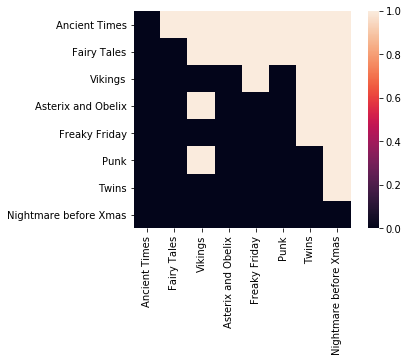

In [12]:
seaborn.heatmap(prefs, square=True)

In [13]:
graph = networkx.DiGraph(prefs.values)

In [14]:
titles = np.array(prefs.index)

for cycle in networkx.simple_cycles(graph):
    print(titles[cycle])

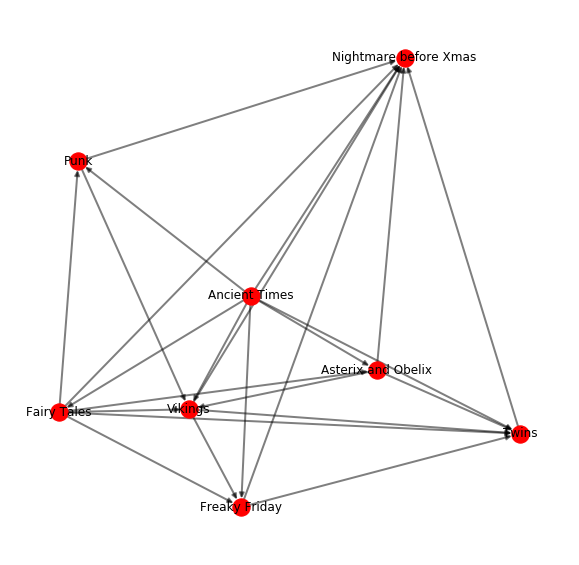

In [15]:
plt.figure(figsize=(10, 10))

pos = networkx.spring_layout(graph) # positions for all nodes

networkx.draw_networkx_nodes(graph, pos)

labels = {idx: list(prefs.index)[idx] for idx in range(prefs.shape[0])}
networkx.draw_networkx_labels(graph, pos, labels)

networkx.draw_networkx_edges(graph, pos, width=2.0, alpha=0.5)

seaborn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([]);

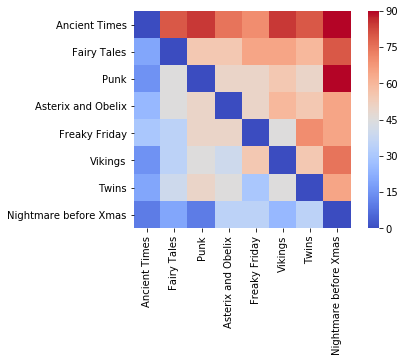

In [16]:
def get_preference(df, c1, c2):
    pair = df.loc[[c1, c2]].values
    prefs = (pair[0, :] < pair[1, :]).sum()
    return prefs / df.shape[1]

titles = list(df.index)
prefs_vals = pd.DataFrame([[get_preference(df, c1, c2) for c2 in titles] for c1 in titles], index=titles, columns=titles) * 100.0

sort_order = prefs_vals.sum(axis=1).argsort()[::-1]
prefs_vals = prefs_vals.iloc[sort_order, sort_order]

seaborn.heatmap(prefs_vals, square=True, cmap="coolwarm")